# HMM Experiments

Lennart Beekhuis, TODO

Bram Otten, 10992456

In [1]:
import nltk
try:
    treebank_sents = nltk.corpus.treebank.tagged_sents(tagset='universal')
except:
    nltk.download()
    treebank_sents = nltk.corpus.treebank.tagged_sents(tagset='universal')

## Defining the model

In [2]:
import numpy as np
from collections import defaultdict


def extract_sentences(treebank_corpus):
    sentences = []
    for observations in treebank_corpus:
        sentences.append([x for x, c in observations])
    return sentences


def extract_tags(treebank_corpus):
    tags = []
    for observations in treebank_corpus:
        tags.append([c for x, c in observations])
    return tags


class HMMLM:
    """
    This is our HMM language model class.

    It will be responsible for estimating parameters by MLE
    as well as computing probabilities using the HMM.

    We will use Laplace smoothing by default (because we do not want 
    to assign 0 probabilities).

    GUIDELINES:
        - by convention we will use the string '-UNK-' for an unknown POS tag
            - and '<unk>' for an unknown word
        - don't forget that with Laplace smoothing the unknown symbols have 
          to be in the support
          of distributions
        - now you will have 2 types of distributions, so you should deal 
          with unknown symbols
          for both of them
        - we also need padding for sentences and tag sequences, by convention 
          we will use
            - '-BOS-' and '-EOS-' for padding tag sequences
            - '<s>' and '</s>' for padding sentences
        - do recall that '-BOS-' is **not** a valid tag
            in other words we never *generate* '-BOS-' tags, we only pretend 
            they occur at
            the 0th position of the tag sequence in order to provide 
            conditioning context for the first actual tag
        - similarly, '<s>' is not a valid word
            in other words, we never *generate* '<s>' as a word
            in fact '<s>' is optional as no emission event is based on it
        - on the other hand, '-EOS-' is a valid tag
            you should model it as the last event of a tag sequence
        - similarly, '</s>' is a valid word
            you should consider it as the last event of a sentence

    You can use whatever data structures you like for cpds
        - we suggest python dict or collections.defaultdict
            but you are free to experiment with list and/or np.array if you 
            like
    """

    def __init__(self, transition_alpha=1.0, emission_alpha=1.0):
        self._vocab = set()
        self._tagset = set()
        self._emission_cpds = dict()
        self._transition_cpds = dict()
        self._transition_alpha = transition_alpha
        self._emission_alpha = emission_alpha

    def tagset(self):
        """
        Return the tagset: a set of all tags seen by the model (including 
        '-UNK-').

        You can modify this if you judge necessary (for example, because 
        you decided  to use different datastructures, but do note that we 
        provide you an implementation of the Viterbi algorithm that
        expects this functionality).
        """
        # the -BOS- tag is just something for internal representation
        #  in case you have added it to the tagset, we are removing it here
        #  as keeping it would be bad for algorithms such as Viterbi
        # the -UNK- tag must be in the support (due to Laplace smoothing)
        #  thus in case you forgot it, we are adding it now
        return self._tagset - {'-BOS-'} | {'-UNK-'}

    def vocab(self):
        """
        Return the vocabulary of words: all words seen by the model 
        (including '<unk>').

        You can modify this if you judge necessary (for example, because 
        you decided to use different datastructures, but do note that 
        we provide you an implementation of the Viterbi algorithm that 
        expects this functionality).
        """
        # the <s> token is just something for internal representation
        #  in case you have added it to the vocabulary, we are removing it here
        # the <unk> word must be in the support (due to Laplace smoothing)
        #  thus in case you forgot it, we are adding it now
        return self._vocab - {'<s>'} | {'<unk>'}

    def preprocess_sentence(self, sentence, bos=True, eos=True):
        """
        Preprocess a sentence by lowercasing its words and possibly padding it.

        :param sentence: a list of tokens (each a string)
        :param bos: if True you will get <s> at the beginning
        :param eos: if True you will get </s> at the end
        :returns: a list of tokens (lowercased strings)
        """
        # lowercase
        sentence = [x.lower() for x in sentence]
        # optional padding
        if bos:
            sentence = ['<s>'] + sentence
        if eos:
            sentence = sentence + ['</s>']
        return sentence

    def preprocess_tag_sequence(self, tag_sequence, bos=True, eos=True):
        """
        Preprocess a tag sequence with optional padding.

        :param tag_sequence: a list of tags (each a string)
        :param bos: if True you will get -BOS- at the beginning
        :param eos: if True you will get -EOS- at the end
        :returns: a list of tokens
        """
        # optional padding
        if bos:
            tag_sequence = ['-BOS-'] + tag_sequence
        if eos:
            tag_sequence = tag_sequence + ['-EOS-']
        return tag_sequence

    def estimate_model(self, treebank):
        """
        :param treebank: a sequence of observations as provided by nltk
            each observation is a list of pairs (x_i, c_i)
            and they have not yet been pre-processed

        Estimate the model parameters.

        This method does not have to return anything, it simply computes 
        the necessary cpds.
        """
        reference_tagged_words = nltk.corpus.treebank.tagged_words(
            tagset='universal')
        self._vocab = set([w for (w, _) in reference_tagged_words])
        self._tagset = set([t for (_, t) in reference_tagged_words])

        self._tagset.add('-EOS-')
        self._tagset.add('-UNK-')
        # Init emissions inbetween so it doesn't unnecessarily contain the BOS
        # tag
        self._emission_cpds = {
            tag: {
                '<unk>': self._emission_alpha
            }
            for tag in self._tagset
        }
        self._tagset.add('-BOS-')
        for key in self._tagset:
            self._transition_cpds[key] = dict.fromkeys(self.tagset(),
                                                       self._transition_alpha)

        sentences = extract_sentences(treebank)
        tree_tags = extract_tags(treebank)
        for sentence_i, tags in enumerate(tree_tags):
            tags = self.preprocess_tag_sequence(tags)
            for i in range(1, len(tags)):
                tag1 = tags[i - 1]
                tag2 = tags[i]
                self._transition_cpds[tag1][tag2] += 1

            sentt = self.preprocess_sentence(sentences[sentence_i])
            for word_i, tag in enumerate(tags):
                word = sentt[word_i]
                if word == '<s>' or word == '</s>' or tag == '-BOS-':
                    continue
                if word not in self._emission_cpds[tag]:
                    self._vocab.add(word)
                    self._emission_cpds[tag][word] = self._emission_alpha
                self._emission_cpds[tag][word] += 1
                # So the value will be 1 + emission_alpha for everything
                # that occurs with this tag and later be made emission_alpha
                # for every word that occurs at all.

        # By now the vocab is full, throw into every tag's emission cpd.
        # This doesn't really make sense (we have unk for this)
        # but gets us closer to the wanted P value.
        for tag in self._tagset:
            if tag == '-BOS-':
                continue
            for word in self._vocab:
                if word not in self._emission_cpds[tag]:
                    self._emission_cpds[tag][word] = self._emission_alpha

    def transition_parameter(self, previous_tag, current_tag):
        """
        This method returns the transition probability for tag given 
        the previous tag.

        Tips: do not forget that we have a smoothed model, thus
            - if the either tag was never seen, you should pretend it 
              to be '-UNK-'

        :param previous_tag: the previous tag (str)
        :param current_tag: the current tag (str)
        :return: transition parameter
        """
        if current_tag not in self.tagset():
            current_tag = '-UNK-'
        if previous_tag not in self.tagset():
            previous_tag = '-UNK-'

        count_pair = self._transition_cpds[previous_tag][current_tag]
        count_single = 0
        for value in self._transition_cpds[previous_tag].values():
            count_single += value

        return count_pair / count_single

    def emission_parameter(self, tag, word):
        """
        This method returns the emission probability for a word given a tag.
        Tips: do not forget that we have a smoothed model, thus
            - if the tag was never seen, you should pretend it to be '-UNK-'
            - similarly, if the word was never seen, you shoud pretend 
              it to be '<unk>'

        :param tag: the current tag (str)
        :param word: the current word (str)
        :return: the emission probability
        """
        word = word.lower()
        if tag not in self.tagset():
            tag = '-UNK-'
        if word not in self._emission_cpds[tag]:
            word = '<unk>'

        count_tag_word = self._emission_cpds[tag][word]
        count_tag = 0
        for value in self._emission_cpds[tag].values():
            count_tag += value

        return count_tag_word / count_tag

    def joint_parameter(self, previous_tag, current_tag, word):
        """
        This method returns the joint probability of (current tag, word) 
        given the previous tag according to Equation (3)

        :param previous_tag: the previous tag (str)
        :param current_tag: the current tag (str)
        :param word: the current word (str)
        :returns: P(word, current_tag|previous_tag)
        """
        return self.transition_parameter(previous_tag, current_tag) * \
            self.emission_parameter(current_tag, word)

    def marginal_x_given_cprev(self, previous_tag, word):
        """
        Return P(x|prev) as defined in Equation (4) by marginalising current 
        tag.

        :param previous_tag: the previous tag (str)
        :param word: the current word (str)
        """
        total = 0
        word = word.lower()
        for cu_tag in self.tagset():
            p = self.joint_parameter(previous_tag, cu_tag, word)
            total += p
        return total

    def log_joint(self, sentence, tag_sequence):
        """
        Implement the logarithm of the joint probability over a sentence and 
        tag sequence as in Equation (8)

        :param sentence: a sequence of words (each a string) not yet preprocessed
        :param tag_sequence: a sequence of tags (each a string) not yet preprocessed
        :returns: log P(x_1^n, c_1^n|n) as defined in Equation (8)
        """
        sentence = self.preprocess_sentence(sentence)
        tag_sequence = self.preprocess_tag_sequence(tag_sequence)

        counter = 0
        for i in range(1, len(sentence)):
            counter += np.log(
                self.joint_parameter(tag_sequence[i - 1], tag_sequence[i],
                                     sentence[i]))

        return counter

    def log_marginal(self, sentence):
        """
        Implement the logarithm of the marginal probability of a sentence as in Equation (9)
            by marginalisation of all possible tag sequences.

        :param sentence: a sequence of words (each a string) not yet preprocessed
        :returns: log P(x_1^m|n) as defined in Equation (9)
        """
        sentence = self.preprocess_sentence(sentence)
        total = 0
        for word in sentence[1:]:
            p = 0
            for previous_tag in self.tagset():
                p += self.marginal_x_given_cprev(previous_tag, word)
            total += np.log(p)
        return total

In [3]:
def log_perplexity(sentences, hmm):
    """
    TYPE YOUR SOLUTION

    For a dataset of sentences (each sentence is a list of words)
        and an instance of the HMMLM class
        return the log perplexity as defined in Equation (12)
    """
    total_log_p = 0
    n = 0
    for sentence in sentences:
        # Only care about words, so use this marginal. Each sentence has
        n += len(sentence)
        total_log_p += hmm.log_marginal(sentence) * (-1 / n)
    return total_log_p  # * (-1 / n)


def accuracy(gold_sequences, pred_sequences):
    """
    Return percentage of instances in the test data that our tagger labeled correctly.

    :param gold_sequences: a list of tag sequences that can be assumed to be correct
    :param pred_sequences: a list of tag sequences predicted by Viterbi
    """

    pred_counter = 0
    token_counter = 0

    for i, gold in enumerate(gold_sequences):
        gold = gold_sequences[i]
        pred = pred_sequences[i]
        for j in range(len(gold)):
            if gold[j] == pred[j]:
                pred_counter += 1
        token_counter += len(pred)

    return pred_counter / token_counter


def viterbi_recursion(sentence, hmm):
    """
    Computes the best possible tag sequence for a given input
    and also returns it log probability.

    This implementation uses recursion.

    :returns: tag sequence, log probability
    """
    # here we pad the sentence with </s> only
    sentence = hmm.preprocess_sentence(sentence, bos=False, eos=True)
    # this is the length (but recall that padding added 1 token)
    n = len(sentence)
    # this is the complete tagset, which for convenience we will turn into a
    # list
    tagset = list(hmm.tagset())
    t = len(tagset)
    # We need a table to store log alpha(i, j) values
    # - where i is an integer from 0 to n-1 which refers to a position in the list `sentence`
    #   i.e. sentence[i]
    # - and j is an integer from 0 to t-1 that refers to a tag in the list `tagset`
    #   i.e. tagset[j]
    # - together (i, j) means that we are setting `C_i = tagset[j]`
    # - we will be exploring the space of possible tags per position
    #   thus our table has as many as n * t cells
    # - Recall that the value \log \alpha(i, j)
    #   corresponds to the log probability value of the best
    #   path (C_1, ..., C_i) such that C_i = j
    #   in other words the log probability of the best sequence up to the ith token where C_i = j
    # At the beginning path probabilities have not been computed, we use a probability of 0 to indicate that
    #  as we will be computing log probabilities, we use -inf instead
    #  numpy arrays are very handy and we can actually use the quantity -inf
    log_alpha_table = np.full([n, t], -float('inf'))
    # In a best path algorithm we are interested in two things
    #  the best score (or best log probability)
    #  as well as the path that corresponds to the best score
    # We compute the best score by moving i forward from 0 to n-1 computing the maximum value
    #  and we traverse the table backwards following the path that led to the maximum
    #  thus we create a table of "back pointers"
    #  this is an integer for each cell (i, j) that tells us which tag `p` for position `i - 1`
    #   leads to the score stored in `log_alpha_table[i, j]`
    back_pointer_table = np.full([n, t], -1, dtype=int)

    # Here we define the log alpha recursion
    def log_alpha(i, j):
        """
        This function returns
                max_{c_1, ..., c_i=j} log P(c_1, ..., c_i=j)
            where i is a (0-based) position in `sentence`
            and j is a (0-based) position in `tagset`
        """
        if i == 0:  # we do not need to tag the 0th position and it should not affect the probability
            return 0.  # np.log(1)
        # When we implement dynamic programs, we like to re-use computations already made
        # thus first of all we test if we have already computed a value for this cell
        # if so, it will not have a zero probability (-inf in log space)
        if log_alpha_table[i, j] != -float('inf'):
            # then we can simply return it
            return log_alpha_table[i, j]
        # At this point we know we have not yet computed a score for this path
        #  thus we proceed to compute it
        # We will have to figure out the log prob of the best prefix
        #  and which tag best continues from it
        # There are exactly t classes that may tag this position
        #  thus we just go over the tagset trying one at a time
        #  and memorise the score we would have if we would select them
        path_max_log_prob = np.full(t, -float('inf'))
        for p in range(t):
            # this is the essential part of the recursion
            # we ask for the best score associated with the previous position
            #  had it been tagged with p
            #  and we incorporate the probability of C_i = tagset[j] given that C_{i-1} = tagset[p]
            # as well as the probability of X_i = sentence[i] given that C_i =
            # tagset[j]
            path_max_log_prob[p] = log_alpha(
                i - 1, p) + np.log(hmm.joint_parameter(tagset[p], tagset[j], sentence[i]))
        # From all possibilities, we are only interested in the best
        log_alpha_table[i, j] = np.max(path_max_log_prob)
        # and we also want to store a pointer to the best
        back_pointer_table[i, j] = np.argmax(path_max_log_prob)
        return log_alpha_table[i, j]

    # Let's get the index associated with -EOS-
    #  which is the tag for the </s> symbol in sentence[-1]
    eos_index = tagset.index('-EOS-')
    # We want the last word in the sentence (</s>) to have the tag -EOS-
    # thus we ask "what's the probability of the best path that ends in
    # -EOS-?"
    max_log_prob = log_alpha(n - 1, eos_index)

    # Here we retrieve the backpointers for the best analysis
    #  the best analisys has n tags
    bwd_argmax = [None] * n
    #  the last tag is the -EOS- symbol
    bwd_argmax[-1] = eos_index
    # Here we maintain the "current tag" c_i
    c_i = eos_index
    for i in range(n - 1, 0, -1):  # we go backwards from c_{n-1} to c_1
        # and set the value of c_{i-1} for the current c_i
        bwd_argmax[i - 1] = back_pointer_table[i, c_i]
        # we need, of course, to update c_i
        c_i = bwd_argmax[i - 1]

    # Here we translate from ids back to actual tags (strings)
    #  we leave the -EOS- symbol out, since it was just a convenience
    #  and return both the tag sequence and the total log probability
    return [tagset[c] for c in bwd_argmax[:-1]], max_log_prob

## Testing the model

In [4]:
# treebank_sents = nltk.corpus.treebank.tagged_sents(tagset='universal')
treebank_training = list(treebank_sents[:3000])
treebank_dev = list(treebank_sents[3000:3100])
treebank_test = list(treebank_sents[3100:])
print(len(treebank_test))

treebank_hmm = HMMLM()
treebank_hmm.estimate_model(treebank_training)

print(treebank_hmm.joint_parameter('DET', 'NOUN', 'book'))
sentence = [x for x, _ in treebank_dev[0]]
tag_sequence = [c for _, c in treebank_dev[0]]
print(treebank_hmm.log_joint(sentence, tag_sequence))

814
8.700521289904906e-05
-207.70297815546238


In [5]:
def make_tag_sents(testset):
    result = []
    for sent in testset:
        to_sent = []
        for _, c in sent:
            to_sent.append(c)
        result.append(to_sent)

    return result


def make_word_sents(testset):
    result = []
    for sent in testset:
        to_sent = []
        for x, _ in sent:
            to_sent.append(x)
        result.append(to_sent)

    return result


def determine_viterbi_rec_accuracy(hmm, golden_std, test_set):
    test_result = []
    for sent in test_set:
        viterbi_path, _ = viterbi_recursion(sent, hmm)
        test_result.append(viterbi_path)

    return(accuracy(golden_std, test_result))


ptb_gold = make_tag_sents(treebank_test)
sents_ptb = make_word_sents(treebank_test)

lim = 2
print(determine_viterbi_rec_accuracy(treebank_hmm,
                                     ptb_gold[:lim],
                                     sents_ptb[:lim]))
# print(determine_viterbi_rec_accuracy(treebank_hmm, ptb_gold, sents_ptb))

0.864406779661017


In [6]:
def viterbi(sentence, hmm):
    """
    Computes the best possible tag sequence for a given input
    and also returns it log probability.

    This implementation should NOT use recursion.

    :returns: tag sequence, log probability
    """
    sentence = hmm.preprocess_sentence(sentence,
                                       bos=False,
                                       eos=False)
    n = len(sentence)
    tagset = list(hmm.tagset())

    # Fill in array, keys are tags, separated by spaces
    V = [{} for _ in range(n)]
    for tag in tagset:
        V[0]['-BOS- ' + tag] = np.log(
            hmm.joint_parameter('-BOS-', tag, sentence[0]))
        #np.log(hmm.emission_parameter(tag, sentence[0]))
    for i in range(1, n):
        # Could prune
        best_prev_tags = max(V[i - 1], key=V[i - 1].get)
        prev_p = V[i - 1][best_prev_tags]
        for tag in tagset:
            V[i][best_prev_tags + ' ' + tag] = prev_p + np.log(
                hmm.joint_parameter(best_prev_tags.split()[-1],
                                    tag, sentence[i]))
    best_tags = max(V[n-1], key=V[n-1].get)
    return best_tags.split()[1:], V[n-1][best_tags]


def determine_viterbi_own_accuracy(hmm, golden_std, test_set):
    test_result = []
    for sent in test_set:
        viterbi_path, _ = viterbi(sent, hmm)
        test_result.append(viterbi_path)

    return(accuracy(golden_std, test_result))


x = "This is a sentence , but very bad.".split()
print("Mine:", viterbi(x, treebank_hmm))
print("Recu:", viterbi_recursion(x, treebank_hmm))
x = "This is a book .".split()
print("Mine:", viterbi(x, treebank_hmm))
print("Recu:", viterbi_recursion(x, treebank_hmm))
lim = 6
print("Mine:", determine_viterbi_own_accuracy(treebank_hmm,
                                              ptb_gold[:lim],
                                              sents_ptb[:lim]))
if lim > 20:
    lim = 20  # mokerbad Wilker
print("Recu:", determine_viterbi_rec_accuracy(treebank_hmm,
                                              ptb_gold[:lim],
                                              sents_ptb[:lim]))

# Unprofessional conclusion: the recursive version REALLY sucks.

Mine: (['DET', 'VERB', 'DET', 'NOUN', '.', 'CONJ', 'ADV', 'VERB'], -61.239278580821974)
Recu: (['PRON', 'VERB', 'DET', 'NOUN', '.', 'CONJ', 'ADV', '.'], -62.86055666422245)
Mine: (['DET', 'VERB', 'DET', 'NOUN', '.'], -31.94496736549541)
Recu: (['PRON', 'VERB', 'DET', 'NOUN', '.'], -32.75258925965308)
Mine: 0.8697916666666666
Recu: 0.8541666666666666


## Running the experiments (TODO)

In [7]:
training_ids = [int(i) for i in open('training.ids') if i.strip()]
development_ids = [int(i) for i in open('development.ids') if i.strip()]
test_ids = [int(i) for i in open('test.ids') if i.strip()]

In [8]:
ptb_training = [treebank_sents[i] for i in training_ids]
ptb_development = [treebank_sents[i] for i in development_ids]
ptb_test = [treebank_sents[i] for i in test_ids]

In [10]:
 def test_parameters(training_set, test_set,
                    parameters_alpha, parameters_beta):

    test_sents = make_word_sents(test_set)
    test_tags = make_tag_sents(test_set)

    result_array = []
    print("** Alpha = transition_alpha, beta = emission_alpha **\n")

    for alpha in parameters_alpha:
        results = []
        for beta in parameters_beta:
            treebank_hmm = HMMLM(transition_alpha=alpha,
                                 emission_alpha=beta)
            treebank_hmm.estimate_model(training_set)
            perp = log_perplexity(test_tags, treebank_hmm)
            viterbi = determine_viterbi_own_accuracy(
                treebank_hmm, test_tags, test_sents)
            results.append((perp, viterbi))
            print("** Results for alpha = " + str(alpha)[:4] +
                  " and beta = " + str(beta)[:4] + "**")
            print("   Perplexity: " + str(perp)[:4] + "        "
                  "Viterbi: " + str(viterbi)[:4])
            print()

        result_array.append(results)

    return result_array


parameters_alpha = [0.01, 0.10, 1.00, 10.0]
parameters_beta = [0.01, 0.10, 1.00, 10.0]
lim = 2
test_parameters(ptb_training[:lim], ptb_development[:lim],
                parameters_alpha, parameters_beta)

** Alpha = transition_alpha, beta = emission_alpha **

** Results for alpha = 0.01 and beta = 0.01**
   Perplexity: 12.3        Viterbi: 0.16

** Results for alpha = 0.01 and beta = 0.1**
   Perplexity: 12.4        Viterbi: 0.16

** Results for alpha = 0.01 and beta = 1.0**
   Perplexity: 12.5        Viterbi: 0.16

** Results for alpha = 0.01 and beta = 10.0**
   Perplexity: 12.5        Viterbi: 0.06

** Results for alpha = 0.1 and beta = 0.01**
   Perplexity: 12.2        Viterbi: 0.25

** Results for alpha = 0.1 and beta = 0.1**
   Perplexity: 12.4        Viterbi: 0.16

** Results for alpha = 0.1 and beta = 1.0**
   Perplexity: 12.5        Viterbi: 0.16

** Results for alpha = 0.1 and beta = 10.0**
   Perplexity: 12.5        Viterbi: 0.06

** Results for alpha = 1.0 and beta = 0.01**
   Perplexity: 12.1        Viterbi: 0.25

** Results for alpha = 1.0 and beta = 0.1**
   Perplexity: 12.4        Viterbi: 0.25

** Results for alpha = 1.0 and beta = 1.0**
   Perplexity: 12.5        Viter

[[(12.312813482574477, 0.16129032258064516),
  (12.496750944420171, 0.16129032258064516),
  (12.567095003977059, 0.16129032258064516),
  (12.576511540223452, 0.06451612903225806)],
 [(12.258362113537132, 0.25806451612903225),
  (12.472661673087462, 0.16129032258064516),
  (12.563145564208686, 0.16129032258064516),
  (12.576089117725154, 0.06451612903225806)],
 [(12.189050799986951, 0.25806451612903225),
  (12.439890058806414, 0.25806451612903225),
  (12.557090696931997, 0.16129032258064516),
  (12.575425812609847, 0.06451612903225806)],
 [(12.167223770991562, 0.25806451612903225),
  (12.429994509805667, 0.25806451612903225),
  (12.55512069213029, 0.25806451612903225),
  (12.575206092161354, 0.16129032258064516)]]

In [ ]:
# Without limit:
test_parameters(ptb_training[:lim], ptb_development[:lim],
                parameters_alpha, parameters_beta)
results = [[(53.448521686290697, 0.8919712793733682),
            (47.330927607654615, 0.8864229765013055),
            (41.96051297236022, 0.8560704960835509),
            (41.161865555645363, 0.7682767624020888)],
           [(53.445369099263594, 0.8919712793733682),
            (47.329609438720318, 0.8864229765013055),
            (41.96014643605119, 0.8560704960835509),
            (41.161812748821752, 0.7682767624020888)],
           [(53.414116822901967, 0.8919712793733682),
            (47.316515993240216, 0.8864229765013055),
            (41.956502095575537, 0.8560704960835509),
            (41.161288040286323, 0.7682767624020888)],
           [(53.126548139688857, 0.8913185378590078),
            (47.193792971447294, 0.8870757180156658),
            (41.922031064051346, 0.8616187989556136),
            (41.156354423292662, 0.7689295039164491)]]

check_alpha = [10.0]
check_beta = [10.0, 1.0]
check2_alpha = [0.01]
check2_beta = [0.01]

test_parameters(ptb_training, ptb_test,
                check_alpha, check_beta)

test_parameters(ptb_training, ptb_test,
                check2_alpha, check2_beta)

# Prepare for the KeyboardInterrupt.

## Other stuff

In [11]:
from tabulate import tabulate
results = [[0.01, 0.01, 53.449, 0.892], [0.01, 0.1, 47.331, 0.887], [0.01, 1.0, 41.961, 0.856], [0.01, 10.0, 41.162, 0.768],
           [0.1, 0.01, 53.445, 0.892], [0.1, 0.1, 47.330, 0.886], [
               0.1, 1.0, 41.960, 0.856], [0.1, 10.0, 41.162, 0.768],
           [1.0, 0.01, 53.414, 0.892], [1.0, 0.1, 47.317, 0.886], [
               1.0, 1.0, 41.957, 0.856], [1.0, 10.0, 41.161, 0.768],
           [10.0, 0.01, 53.127, 0.891], [10.0, 0.1, 47.194, 0.887], [10.0, 1.0, 41.922, 0.862], [10.0, 10.0, 41.156, 0.769]]
headers = ['alpha', 'beta', 'ppl', 'vit']
print(tabulate(results, headers=headers))

  alpha    beta     ppl    vit
-------  ------  ------  -----
   0.01    0.01  53.449  0.892
   0.01    0.1   47.331  0.887
   0.01    1     41.961  0.856
   0.01   10     41.162  0.768
   0.1     0.01  53.445  0.892
   0.1     0.1   47.33   0.886
   0.1     1     41.96   0.856
   0.1    10     41.162  0.768
   1       0.01  53.414  0.892
   1       0.1   47.317  0.886
   1       1     41.957  0.856
   1      10     41.161  0.768
  10       0.01  53.127  0.891
  10       0.1   47.194  0.887
  10       1     41.922  0.862
  10      10     41.156  0.769


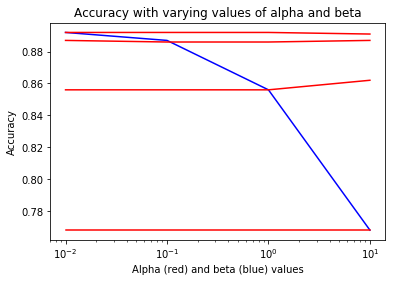

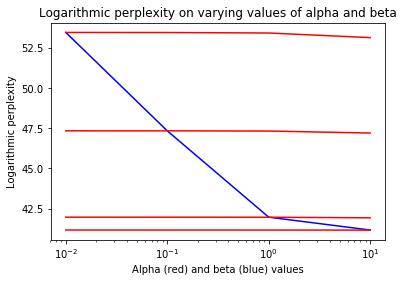

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.semilogx(subsy=[0.01, 0.1, 1.0, 10.0])
plt.yticks([0.78, 0.8, 0.82, 0.84, 0.86, 0.88])
plt.plot([0.01, 0.1, 1.0, 10.0], [0.892, 0.887, 0.856, 0.768], 'b')
plt.plot([0.01, 0.1, 1.0, 10.0], [0.892, 0.892, 0.892, 0.891], 'r')
plt.plot([0.01, 0.1, 1.0, 10.0], [0.887, 0.886, 0.886, 0.887], 'r')
plt.plot([0.01, 0.1, 1.0, 10.0], [0.856, 0.856, 0.856, 0.862], 'r')
plt.plot([0.01, 0.1, 1.0, 10.0], [0.768, 0.768, 0.768, 0.768], 'r')
plt.xlabel('Alpha (red) and beta (blue) values')
plt.ylabel('Accuracy')
plt.title('Accuracy with varying values of alpha and beta')
plt.show()


plt.semilogx(subsy=[0.01, 0.1, 1.0, 10.0])
plt.yticks([42.5, 45, 47.5, 50, 52.5])
plt.plot([0.01, 0.1, 1.0, 10.0], [53.449, 47.331, 41.961, 41.162], 'b')
plt.plot([0.01, 0.1, 1.0, 10.0], [53.449, 53.445, 53.414, 53.127], 'r')
plt.plot([0.01, 0.1, 1.0, 10.0], [47.331, 47.33, 47.317, 47.194], 'r')
plt.plot([0.01, 0.1, 1.0, 10.0], [41.961, 41.96, 41.957, 41.922], 'r')
plt.plot([0.01, 0.1, 1.0, 10.0], [41.162, 41.162, 41.161, 41.156], 'r')
plt.xlabel('Alpha (red) and beta (blue) values')
plt.ylabel('Logarithmic perplexity')
plt.title('Logarithmic perplexity on varying values of alpha and beta')

plt.show()

In [ ]:
# # Optional: Brown treebank too

# brown_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')
# brown_training = list(brown_sentences[:56000])
# brown_dev = list(brown_sentences[56000:56340])
# brown_test = list(brown_sentences[56340:])

# brown_hmm = HMMLM()
# brown_hmm.estimate_model(treebank_training)

# print(brown_hmm.joint_parameter('DET', 'NOUN', 'book'))
# sentence = [x for x, _ in treebank_dev[0]]
# tag_sequence = [c for _, c in treebank_dev[0]]
# print(brown_hmm.log_joint(sentence, tag_sequence))

# brown_gold = make_tag_sents(brown_test)
# sents_brown = make_word_sents(brown_test)

# print(determine_viterbi_rec_accuracy(
#     brown_hmm, brown_gold[:5], sents_brown[:5]))
# # print(determine_viterbi_rec_accuracy(brown_hmm, brown_gold, sents_brown))
# # print(determine_viterbi_rec_accuracy(brown_hmm, ptb_gold, sents_ptb))
# # print(determine_viterbi_rec_accuracy(treebank_hmm, brown_gold, sents_brown))